In [1]:
!pip install langgraph

In [2]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env")

True

In [3]:
from langchain_openai import ChatOpenAI

# 모델 초기화
model = ChatOpenAI(model="gpt-4o-mini")
model.invoke('안녕하세요!')

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C55Ord7MkTXC6QTgx9UPmghGoY5Co', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--082d1379-30f6-4e3e-a2a5-e790a853a73d-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

#### 상태 정의하기

랭그래프에서 상태는 언어 모델이 임무를 수행하면서 현재 상태를 명확히 관리할 수 있도록 돕는 요소입니다.

In [4]:
# 상태 정의하기

from typing import Annotated # annotated는 타입 힌트를 사용할 때 사용하는 함수
from typing_extensions import TypedDict # TypedDict는 딕셔너리 타입을 정의할 때 사용하는 함수

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):	# State 클래스는 TypedDict를 사용하여 딕셔너리 형태로 관리
    """
    State 클래스는 TypedDict를 상속받습니다.

    속성:
        messages (Annotated[list[str], add_messages]): 메시지들은 "list" 타입을 가집니다.   # messages라는 변수만 포함되며, 이는 Annoted를 사용해 문자열로 구성된 리스트 형식임
       'add_messages' 함수는 이 상태 키가 어떻게 업데이트되어야 하는지를 정의합니다.  # add_messages 함수를 추가. 이는 langgraph에서 제공하는 함수로, 문자열이 주어질 때 이를 추가하는 기능 수행
        (이 경우, 메시지를 덮어쓰는 대신 리스트에 추가합니다)
    """
    messages: Annotated[list[str], add_messages]

# StateGraph 클래스를 사용하여 State 타입의 그래프를 생성합니다.
graph_builder = StateGraph(State)   # 생성한 State 를 이용해 StateGraph를 만들어 graph_builder라는 변수에 담는다.

# 이렇게 만들어진 graph_builder에 노드와 엣지들을 연결할 예정

In [5]:
# 노드 생성하기
def generate(state: State):
    """
    주어진 상태를 기반으로 챗봇의 응답 메시지를 생성합니다.

    매개변수:
    state (State): 현재 대화 상태를 나타내는 객체로, 이전 메시지들이 포함되어 있습니다.
		
    반환값:
    dict: 모델이 생성한 응답 메시지를 포함하는 딕셔너리. 
          형식은 {"messages": [응답 메시지]}입니다.
    """ 
    return {"messages": [model.invoke(state["messages"])]}

graph_builder.add_node("generate", generate)

In [6]:
# 엣지 설정하기
graph_builder.add_edge(START, "generate")
graph_builder.add_edge("generate", END)    

graph = graph_builder.compile()

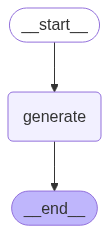

In [7]:
# 그래프 도식화하기
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception: 
    pass

In [8]:
# 그래프를 이용해 답변 얻기
response = graph.invoke({"messages": ["안녕하세요! 저는 마틴입니다."]})

print(type(response))  # 응답의 타입을 출력합니다.
print(response)  # 응답 내용을 출력합니다.

<class 'dict'>
{'messages': [HumanMessage(content='안녕하세요! 저는 마틴입니다.', additional_kwargs={}, response_metadata={}, id='03a4ab03-390f-4b34-ac80-f2500d0bf578'), AIMessage(content='안녕하세요, 마틴님! 만나서 반갑습니다. 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 15, 'total_tokens': 35, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-C55OsonVGLA4515QlmZtBOX4a6qnE', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e810e62d-7eea-4e84-8f9d-1b0d6a37ef37-0', usage_metadata={'input_tokens': 15, 'output_tokens': 20, 'total_tokens': 35, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


In [9]:
response["messages"].append("제 이름을 아시나요?")
graph.invoke(response)  # 이전 응답을 기반으로 그래프를 다시 실행합니다.

{'messages': [HumanMessage(content='안녕하세요! 저는 마틴입니다.', additional_kwargs={}, response_metadata={}, id='03a4ab03-390f-4b34-ac80-f2500d0bf578'),
  AIMessage(content='안녕하세요, 마틴님! 만나서 반갑습니다. 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 15, 'total_tokens': 35, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-C55OsonVGLA4515QlmZtBOX4a6qnE', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e810e62d-7eea-4e84-8f9d-1b0d6a37ef37-0', usage_metadata={'input_tokens': 15, 'output_tokens': 20, 'total_tokens': 35, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(conte

In [10]:
# 스트림 방식으로 출력하기
inputs = {"messages": [("human", "한국과 일본의 관계에 대해 자세히 알려줘")]}
for chunk, _ in graph.stream(inputs, stream_mode="messages"):
    print(chunk.content, end="")

한국과 일본은 역사적으로 복잡하고 때로는 갈등을 겪어온 관계입니다. 이 두 나라 사이의 관계는 문화적, 경제적, 정치적 여러 측면에서 긴밀하지만, 역사적 사건들로 인해 긴장 상태를 유지하기도 합니다. 아래는 이들 관계의 주요한 측면들입니다.

### 역사적 배경
1. **한일 병합 (1910-1945)**:
   - 한국은 1910년에 일본에 의해 강제로 병합되었으며, 이 시기는 식민지 통치 하에 많은 고통을 받았습니다. 이 시기에 일본은 한국의 문화와 언어를 억압하고, 다양한 자원을 착취했습니다.

2. **제2차 세계 대전 이후**:
   - 한국은 1945년에 해방되었지만, 분단이라는 결과를 낳았습니다. 이후 일본은 한국과의 관계를 정리하기 위해 1965년에 한일기본조약을 체결하였고, 이 조약에 따라 일본은 한국에 대한 경제 지원을 약속했습니다.

### 현대의 관계
1. **경제적 관계**:
   - 한국과 일본은 서로 중요한 경제적 파트너입니다. 두 나라는 무역을 통해 서로에게 의존하고 있으며, 기술과 산업에서도 협력하고 있습니다. 그러나 갈등이 생길 경우, 이러한 경제 관계에 부정적인 영향을 미칠 수 있습니다.

2. **문화적 교류**:
   - 두 나라 사이에 문화적 교류가 활발하게 이루어지고 있습니다. 한국의 K-팝과 드라마, 일본의 애니메이션과 만화가 서로의 나라에서 큰 인기를 끌고 있습니다. 이러한 문화적 요소들은 양국 간의 이해를 높이는 데 기여하고 있습니다.

3. **정치적 갈등**:
   - 역사적 사안, 특히 일본의 식민지 통치와 관련된 문제(예: 강제징용, 위안부 문제 등)는 여전히 민감한 이슈로 남아 있습니다. 이러한 문제들은 양국 간의 외교적 긴장을 유발할 수 있습니다.

4. **안보 협력**:
   - 북한의 위협 증가로 인해 한국과 일본은 군사 및 안보 협력을 위한 채널을 유지하고 있습니다. 미국과의 삼각 동맹이 중요한 역할을 하며, 북한의 핵 및 미사일 문제에 대해 함께 대처하고 있습니다.

### 최근 동향
- 최근 